In [1]:
import os
os.chdir("..")
import numpy as np
from CPSL_Radar.Analyzer import Analyzer
from CPSL_Radar.datasets.Dataset_Generator import DatasetGenerator
from torchvision import transforms

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#initialize the dataset generator
#campus dataset folders
campus_folder = "/home/david/CPSL_Ground/campus_test_dataset/"
#campus_folder = "/home/locobot/data/campus_datasets/"

campus_scenarios = ["scene_{}".format(i+1) for i in range(3)]
campus_test_scenarios = ["scene_{}_test".format(i+1) for i in range(7)]
campus_test_scenarios_spin = ["scene_{}_test_spin".format(i) for i in range(3,5)]

train_scenarios = [os.path.join(campus_folder,scenario_folder) for 
                  scenario_folder in campus_scenarios]

test_scenarios = [os.path.join(campus_folder,scenario_folder) for 
                  scenario_folder in campus_test_scenarios]

test_scenarios_spin = [os.path.join(campus_folder,scenario_folder) for 
                  scenario_folder in campus_test_scenarios_spin]
# wilkenson dataset
# wilkenson_folder = "/data/david/CPSL_Ground/wilkenson_datasets"
# wilkenson_scenarios = ["scene_{}".format(i+1) for i in range(10)]

# wilkenson_test_scenarios = ["scene_{}_test".format(i+1) for i in range(10)]

# train_scenarios.extend([os.path.join(wilkenson_folder,scenario_folder) for
#                    scenario_folder in wilkenson_scenarios])
# test_scenarios.extend([os.path.join(wilkenson_folder,scenario_folder) for
#                    scenario_folder in wilkenson_test_scenarios])

#box_dataset_folders
# box_folder = "/data/david/CPSL_Ground/box_datasets/"

# box_scenarios = ["scene_{}".format(i+1) for i in range(5)]

# train_scenarios.extend(
#     [os.path.join(box_folder,scenario_folder) for
#      scenario_folder in box_scenarios[0:-1]]
# )

# test_scenarios.extend([
#     os.path.join(box_folder,scenario_folder) for 
#     scenario_folder in box_scenarios[-1]])

scenarios_to_use = train_scenarios

#location that we wish to save the dataset to
generated_dataset_path = "/home/david/CPSL_Ground/test/"
#generated_dataset_path = "/home/locobot/data/test/"

#specifying the names for the files
generated_file_name = "frame"
radar_data_folder = "radar"
lidar_data_folder = "lidar"

#basic dataset settings
num_chirps_to_save = 40
num_previous_frames = 0
use_average_range_az = False

#initialize the DatasetGenerator
dataset_generator = DatasetGenerator()

dataset_generator.config_generated_dataset_paths(
    generated_dataset_path=generated_dataset_path,
    generated_file_name=generated_file_name,
    generated_radar_data_folder=radar_data_folder,
    generated_lidar_data_folder=lidar_data_folder,
    clear_existing_data=False
)

#configure the radar data processor
dataset_generator.config_radar_data_processor(
    max_range_bin=64,
    num_chirps_to_save=num_chirps_to_save,
    num_previous_frames=num_previous_frames,
    use_average_range_az= use_average_range_az,
    radar_fov= [-0.87, 0.87], #+/- 50 degrees
    num_angle_bins=64,
    power_range_dB=[60,105],
    chirps_per_frame= 64,
    rx_channels = 4,
    tx_channels = 1,
    samples_per_chirp = 64,
    adc_sample_rate_Hz = 2e6,
    chirp_slope_MHz_us= 35,
    start_freq_Hz=77e9,
    idle_time_us = 100,
    ramp_end_time_us = 100
)

#configure the lidar data processor
dataset_generator.config_lidar_data_processor(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[-np.pi/2 - 0.87,-np.pi/2 + 0.87], #[-np.pi /2 , np.pi /2],
    num_angle_bins=48,
    num_previous_frames=num_previous_frames
)

DatasetGenerator._check_for_directory: found directory /home/david/CPSL_Ground/test/
DatasetGenerator._check_for_directory: found directory /home/david/CPSL_Ground/test/radar
DatasetGenerator._check_for_directory: found directory /home/david/CPSL_Ground/test/lidar
max range: 8.5654988m
num actual angle bins: 48


In [3]:
#generate the test dataset if needed
# dataset_generator.generate_dataset()

In [4]:
from CPSL_Radar.models.unet import unet

#initialize the transforms
unet_transforms = [
    transforms.ToTensor(),
    transforms.Resize((64,48))
]

#initialize the unet
unet_model = unet(
    encoder_input_channels= 40,
    encoder_out_channels= (64,128,256),
    decoder_input_channels= (512,256,128),
    decoder_out_channels= 64,
    output_channels= 1,
    retain_dimmension= False,
    input_dimmensions= (64,48)
)

#initialize the viewer
result_analyzer = Analyzer(
    dataset_generator=dataset_generator,
    model=unet_model,
    transforms_to_apply= unet_transforms,
    working_dir="working_dir/",
    model_state_dict_file_name="trained_campus_chirps_smaller.pth",
    cuda_device="cuda:0"
)

Analyzer.__init__: using GPU: cuda:0


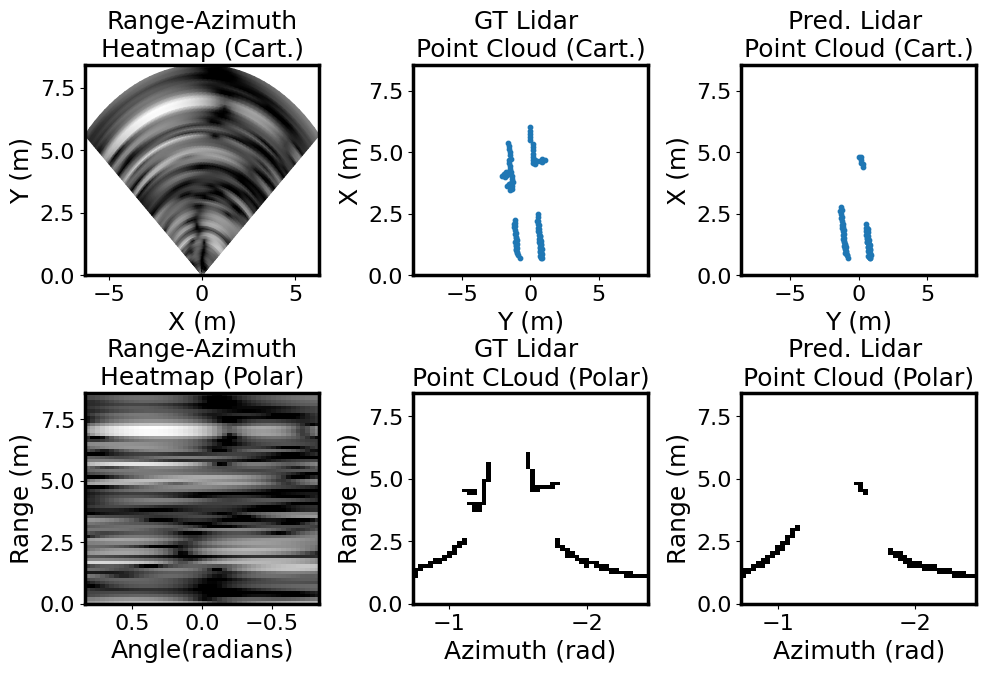

In [5]:
#show the results for a given sample
result_analyzer.view_result(sample_idx=200)

In [6]:
#to assess the speed of model computations
# result_analyzer.compute_all_results(
#     scenario_folders=scenarios_to_use,
#     radar_data_folder=radar_data_folder,
#     lidar_data_folder=lidar_data_folder
# )

In [7]:
#computing all distance metrics
save_distances = False
file_name = "40_chirps"

chamfer_distances, hausdorff_distances,chamfer_distances_radarHD, modified_hausdorff_distances_radarHD = \
    result_analyzer.compute_all_distance_metrics(
        save_to_file=save_distances,
        file_name=file_name
    )

Analyzer.compute_all_distance_metrics: Computing distance metrics


  0%|          | 0/4767 [00:00<?, ?it/s]

100%|██████████| 4767/4767 [00:34<00:00, 136.93it/s]

Analyzer.compute_all_distance_metrics: number failed predictoins 0 of 4767 (0.0%)


In [8]:
#to compute summary statistics
result_analyzer.show_summary_statistics(chamfer_distances,hausdorff_distances,chamfer_distances_radarHD, modified_hausdorff_distances_radarHD)

,Metric,Hausdorff,Chamfer,Chamfer (RadarHD),Modified Hausdorff (RadarHD)
0,Mean,2.200747,0.697319,0.277336,0.216497
1,Median,1.928404,0.457962,0.256177,0.152777
2,90th percentile,4.019708,1.621603,0.460374,0.413888


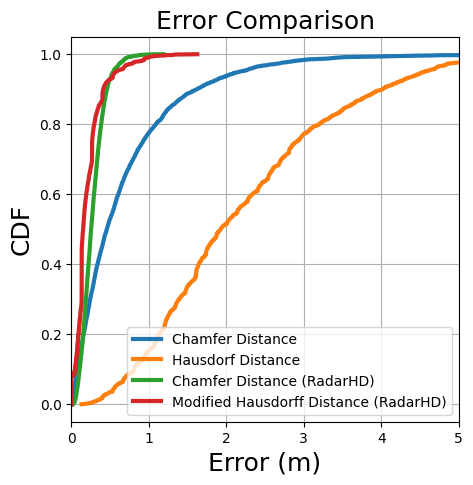

In [9]:
result_analyzer.plot_distance_metrics_cdfs(chamfer_distances,hausdorff_distances,chamfer_distances_radarHD,modified_hausdorff_distances_radarHD)